In [1]:
import os

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1

In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_x = ImageFolder(root='data/photo', transform=transform)
dataset_y = ImageFolder(root='data/monet', transform=transform)

train_loader_x = DataLoader(dataset_x, batch_size=batch_size, shuffle=True)
train_loader_y = DataLoader(dataset_y, batch_size=batch_size, shuffle=True)

# Architecture and losses

In [5]:
# Define the LSGAN loss as in https://arxiv.org/pdf/1611.04076
def lsgan_loss(pred, target):
    return torch.mean((pred - target) ** 2)

# Define the cycle consistency loss as in https://arxiv.org/pdf/1703.10593 
def cycle_consistency_loss(real, reconstructed):
    return torch.mean(torch.abs(real - reconstructed))

In [6]:
import torch
import torch.nn as nn

# U net inspired architecture
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False),
            nn.InstanceNorm2d(64), # Normalization layer, equivalent to batch norm but for style transfer
            nn.ReLU(True),
            # Downsampling
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256),
            nn.ReLU(True),
            # Residual blocks - pretty deep network - avoid vanishing gradients
            *[ResidualBlock(256) for _ in range(9)],
            # Upsampling
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# CNN with linear head
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, bias=False)
        )

    def forward(self, x):
        return self.main(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(channels),
            nn.ReLU(True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

# Training
$$
L(G, F, D_X, D_Y) = \mathcal{L}_{GAN}(G, D_Y, X, Y) + \mathcal{L}_{GAN}(F, D_X, Y, X) + \lambda \mathcal{L}_{cyc}(G, F)
$$
from https://arxiv.org/pdf/1703.10593
- update the discriminators with \mathcal{L}_{GAN} (adversarial losses)
- update the generators with \mathcal{L}_{GAN} and \mathcal{L}_{cyc} (adversarial and cycle consistency losses)

In [6]:
import pickle
from torch import optim
import os

G = Generator().to(device)
F = Generator().to(device)
Dx = Discriminator().to(device)
Dy = Discriminator().to(device)

lr = 0.0002
beta1 = 0.5
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
F_optimizer = optim.Adam(F.parameters(), lr=lr, betas=(beta1, 0.999))
Dx_optimizer = optim.Adam(Dx.parameters(), lr=lr, betas=(beta1, 0.999))
Dy_optimizer = optim.Adam(Dy.parameters(), lr=lr, betas=(beta1, 0.999))


cycle_losses = []
Dx_losses = []
Dy_losses = []
G_losses = []
F_losses = []
os.makedirs("weights", exist_ok=True)


def train(epochs, train_loader_x, train_loader_y, G, F, Dx, Dy, G_optimizer, F_optimizer, Dx_optimizer, Dy_optimizer, cycle_losses, Dx_losses, Dy_losses, G_losses, F_losses, lambda_param=10, weight_dir="weights"):
    for epoch in range(1, epochs + 1):
        for i, (real_x, real_y) in enumerate(zip(train_loader_x, train_loader_y)):
            real_x = real_x[0]
            real_y = real_y[0] # drop labels generated by ImageFolder
            real_x = real_x.to(device)
            real_y = real_y.to(device)
    
            # Train Discriminators
            Dx_optimizer.zero_grad()
            Dy_optimizer.zero_grad()
    
            fake_y = G(real_x)
            fake_x = F(real_y)
    
            # adversarial losses of the discriminators min log(1 - D(x)) + log(D(G(x))) => min (1 - D(x))^2 + D(G(x))^2
            Dx_real_loss = lsgan_loss(Dx(real_x), torch.ones_like(Dx(real_x)))
            Dx_fake_loss = lsgan_loss(Dx(fake_x.detach()), torch.zeros_like(Dx(fake_x)))
            Dx_loss = (Dx_real_loss + Dx_fake_loss) * 0.5
            
            Dy_real_loss = lsgan_loss(Dy(real_y), torch.ones_like(Dy(real_y)))
            Dy_fake_loss = lsgan_loss(Dy(fake_y.detach()), torch.zeros_like(Dy(fake_y)))
            Dy_loss = (Dy_real_loss + Dy_fake_loss) * 0.5
    
            # backpropagate discriminator losses
            Dx_loss.backward()
            Dy_loss.backward()
            Dx_optimizer.step()
            Dy_optimizer.step()
    
            # Train Generators
            G_optimizer.zero_grad()
            F_optimizer.zero_grad()
    
            fake_y = G(real_x)
            fake_x = F(real_y)
    
            # adversarial losses of the generators max log(D(G(x))) => min (1 - D(G(x)))^2
            G_loss = lsgan_loss(Dy(fake_y), torch.ones_like(Dy(fake_y)))
            F_loss = lsgan_loss(Dx(fake_x), torch.ones_like(Dx(fake_x)))
    
            cycle_x = F(fake_y)
            cycle_y = G(fake_x)
    
            # consistency loss - l1 norm between real and reconstructed images - min l1 error
            cycle_x_loss = cycle_consistency_loss(real_x, cycle_x)
            cycle_y_loss = cycle_consistency_loss(real_y, cycle_y)
            total_cycle_loss = (cycle_x_loss + cycle_y_loss) * lambda_param
    
            # backpropagate generator losses sum adversarial and cycle loss
            total_G_loss = G_loss + total_cycle_loss
            total_F_loss = F_loss + total_cycle_loss
    
            total_G_loss.backward(retain_graph=True) # otherwise cannot backward pass total_F_loss -> reuse total_cycle loss
            total_F_loss.backward()
            G_optimizer.step()
            F_optimizer.step()
    
            if i % 1 == 0:
                print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(train_loader_x)}], "
                      f"cycle loss {total_cycle_loss.item()}"
                      f"Dx Loss: {Dx_loss.item()}, Dy Loss: {Dy_loss.item()}, "
                      f"G Loss: {total_G_loss.item()}, F Loss: {total_F_loss.item()}")
                
                cycle_losses.append(total_cycle_loss.item())
                Dx_losses.append(Dx_loss.item())
                Dy_losses.append(Dy_loss.item())
                G_losses.append(total_G_loss.item())
                F_losses.append(total_F_loss.item())

        if epoch % 10 == 0:
            torch.save(G.state_dict(), f"{weight_dir}/G_epoch_{epoch}.pth")
            torch.save(F.state_dict(), f"{weight_dir}/F_epoch_{epoch}.pth")
    return cycle_losses, Dx_losses, Dy_losses, G_losses, F_losses    


# Experiments influence of lambda - cycle consistency loss 
lower is expected to encourage more style transfer wheres higher values should encourage more content preservation

In [ ]:
lambdas = [1, 2, 5, 10, 20]
weight_dir = "weights"
losses_dir = "losses"
os.makedirs(weight_dir, exist_ok=True)
os.makedirs(losses_dir, exist_ok=True)
lr = 0.0002
beta1 = 0.5
num_epochs = 30
for l in lambdas:
    weight_dir_for_lambda = f"{weight_dir}/{l}"
    os.makedirs(weight_dir_for_lambda, exist_ok=True)
    G = Generator().to(device)
    F = Generator().to(device)
    Dx = Discriminator().to(device)
    Dy = Discriminator().to(device)
    
    G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
    F_optimizer = optim.Adam(F.parameters(), lr=lr, betas=(beta1, 0.999))
    Dx_optimizer = optim.Adam(Dx.parameters(), lr=lr, betas=(beta1, 0.999))
    Dy_optimizer = optim.Adam(Dy.parameters(), lr=lr, betas=(beta1, 0.999))
    
    cycle_losses, Dx_losses, Dy_losses, G_losses, F_losses = train(30, train_loader_x, train_loader_y, G, F, Dx, Dy, G_optimizer, F_optimizer, Dx_optimizer, Dy_optimizer, cycle_losses, Dx_losses, Dy_losses, G_losses, F_losses, lambda_param=l, weight_dir=weight_dir_for_lambda)
    with open(f"{weight_dir_for_lambda}/losses_{l}.pkl", "wb") as f:
        pickle.dump({
            "cycle_losses": cycle_losses,
            "Dx_losses": Dx_losses,
            "Dy_losses": Dy_losses,
            "G_losses": G_losses,
            "F_losses": F_losses
        }, f)

# inference

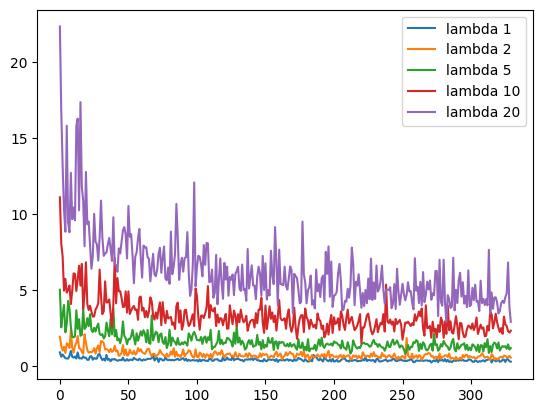

In [16]:
# plot losses for all lambdas
import matplotlib.pyplot as plt
import pickle
import os

lambdas = [1, 2, 5, 10, 20]
losses_dir = "losses"
for i, l in enumerate(lambdas):
    with open(f"{losses_dir}/losses_{l}.pkl", "rb") as f:
        losses = pickle.load(f)
        # plot every 330 steps in each run, list of losses weren't cleared between runs
        plt.plot(losses["cycle_losses"][330*i : 330*(i+1)], label=f"lambda {l}")
        plt.legend()
plt.show()  

for lambda  1  min cycle loss  0.21913138031959534


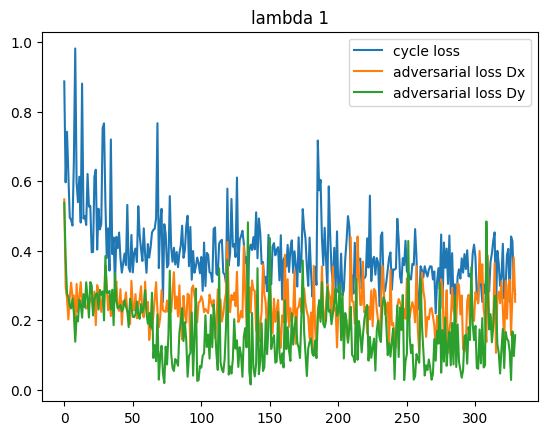

for lambda  2  min cycle loss  0.1791011095046997


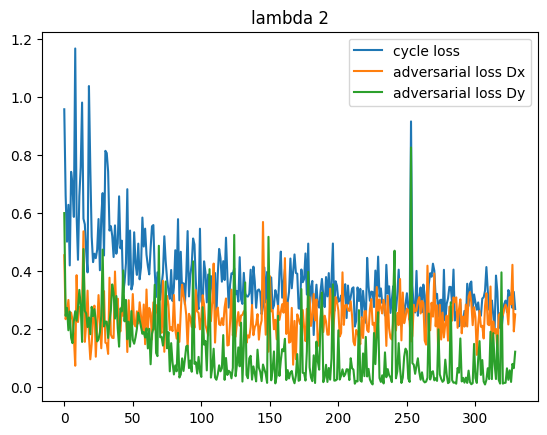

for lambda  5  min cycle loss  0.15850555896759033


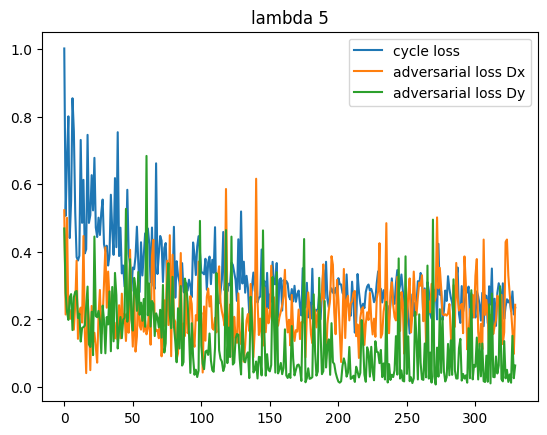

for lambda  10  min cycle loss  0.14942734241485595


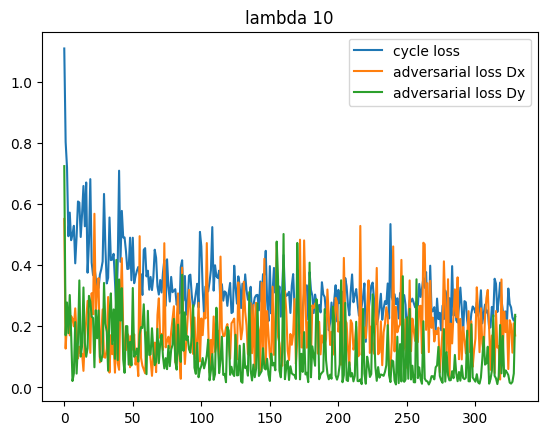

for lambda  20  min cycle loss  0.14460862874984742


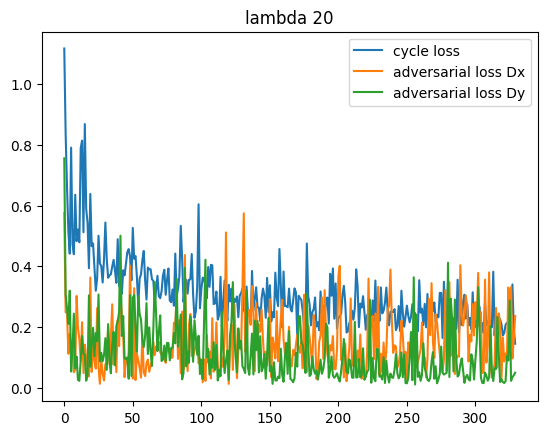

In [26]:
for i, l in enumerate(lambdas):
    with open(f"{losses_dir}/losses_{l}.pkl", "rb") as f:
        losses = pickle.load(f)
        cycle_losses_not_multilied = [x / l for x in losses["cycle_losses"][330*i : 330*(i+1)]]
        print("for lambda ", l, " min cycle loss ", min(cycle_losses_not_multilied))
        plt.plot(cycle_losses_not_multilied, label="cycle loss")
        plt.plot(losses["Dx_losses"][330*i : 330*(i+1)], label="adversarial loss Dx")
        plt.plot(losses["Dy_losses"][330*i : 330*(i+1)], label=f"adversarial loss Dy")
        plt.legend()
        plt.title(f"lambda {l}")
        plt.show()

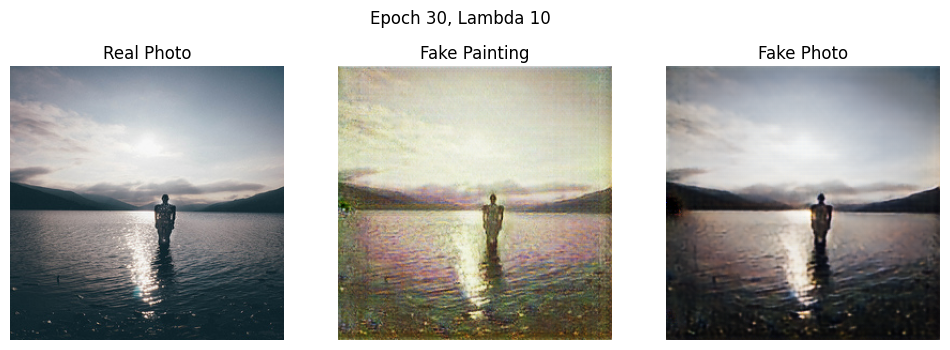

In [21]:
def unnormalize(tensor):
    return (tensor * 0.5) + 0.5
def load_weights_and_generate_images(real_photo, lambda_param, epoch):
    # Load the weights
    trained_generator_G = Generator().to(device)
    trained_generator_G.load_state_dict(torch.load(f"weights/{lambda_param}/G_epoch_{epoch}.pth"))

    trained_generator_F = Generator().to(device)
    trained_generator_F.load_state_dict(torch.load(f"weights/{lambda_param}/F_epoch_{epoch}.pth"))

    # Generate images
    real_photo = real_photo.to(device)
    fake_painting = trained_generator_G(real_photo)
    fake_photo = trained_generator_F(fake_painting)

    # Unnormalize the images
    real_photo = unnormalize(real_photo)
    fake_painting = unnormalize(fake_painting)
    fake_photo = unnormalize(fake_photo)

    # Plot the results
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(real_photo[0].detach().cpu().permute(1, 2, 0))
    axes[0].set_title("Real Photo")
    axes[0].axis("off")
    axes[1].imshow(fake_painting[0].detach().cpu().permute(1, 2, 0))
    axes[1].set_title("Fake Painting")
    axes[1].axis("off")
    axes[2].imshow(fake_photo[0].detach().cpu().permute(1, 2, 0))
    axes[2].set_title("Fake Photo")
    axes[2].axis("off")
    fig.suptitle(f"Epoch {epoch}, Lambda {lambda_param}")
    plt.show()


# Call the function with the desired epoch number and the image tensor
data_iter = iter(train_loader_x)
real_photo = next(data_iter)[0]  # Get an image tensor from the data loader
load_weights_and_generate_images(real_photo, 10, 30)

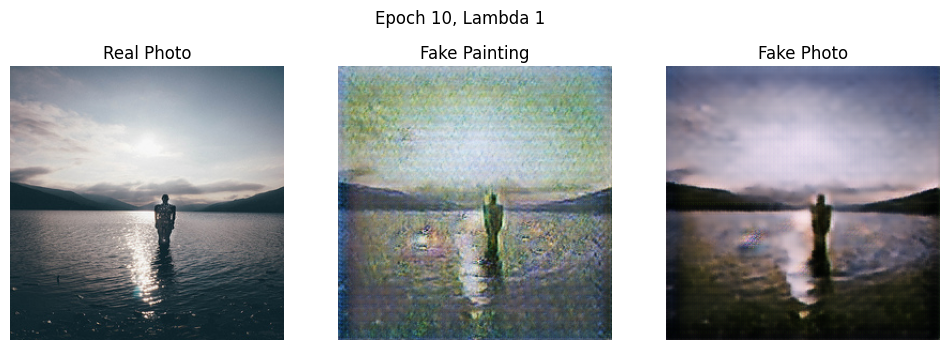

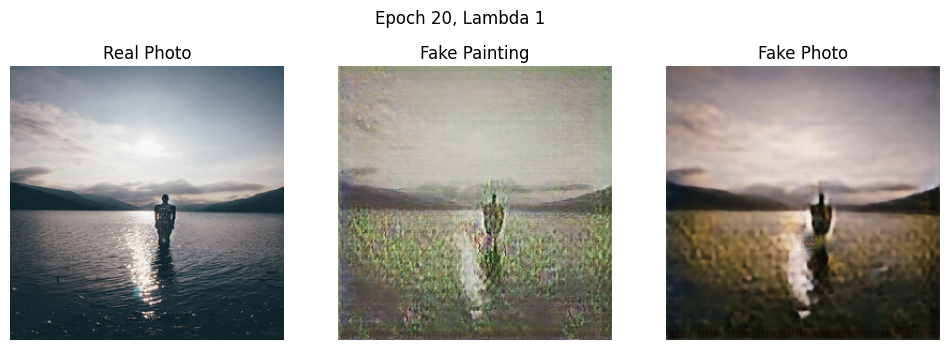

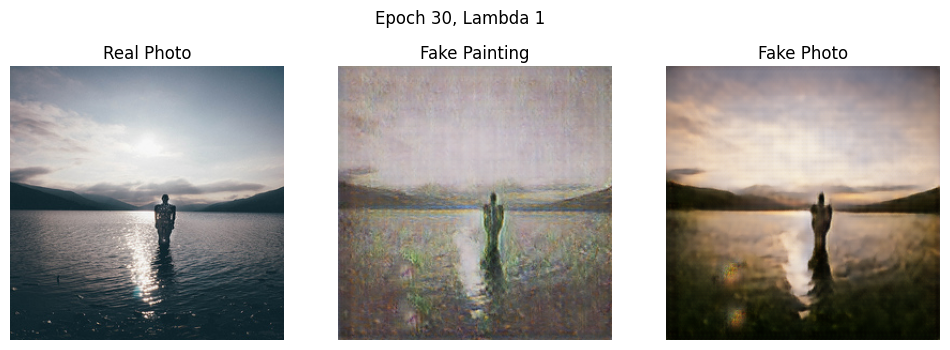

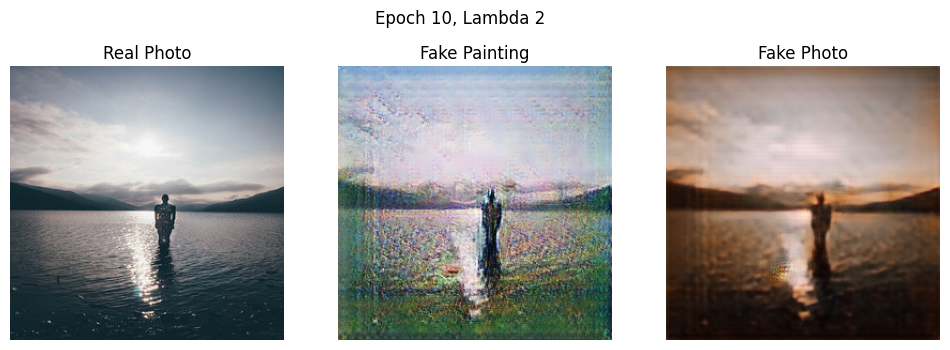

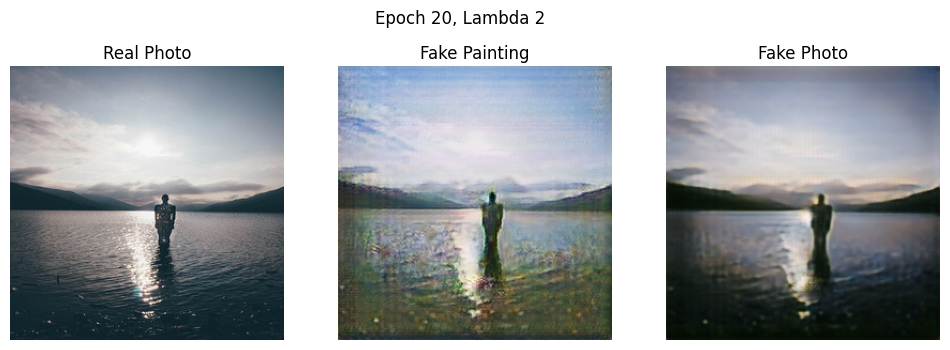

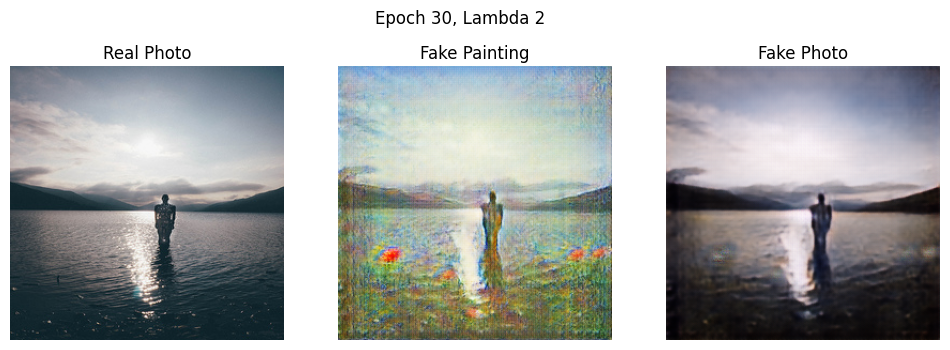

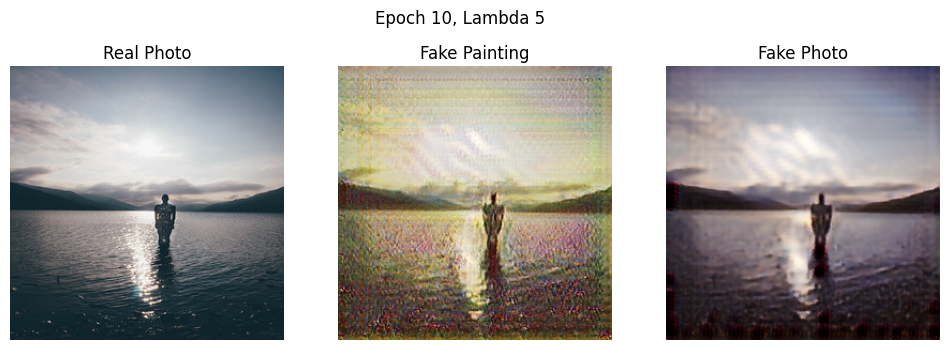

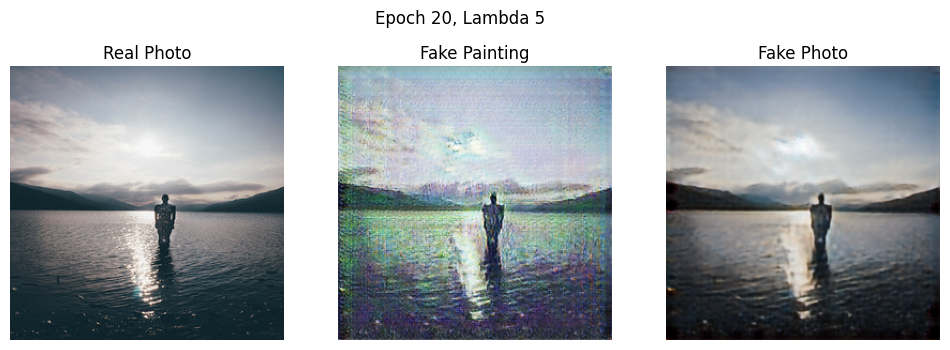

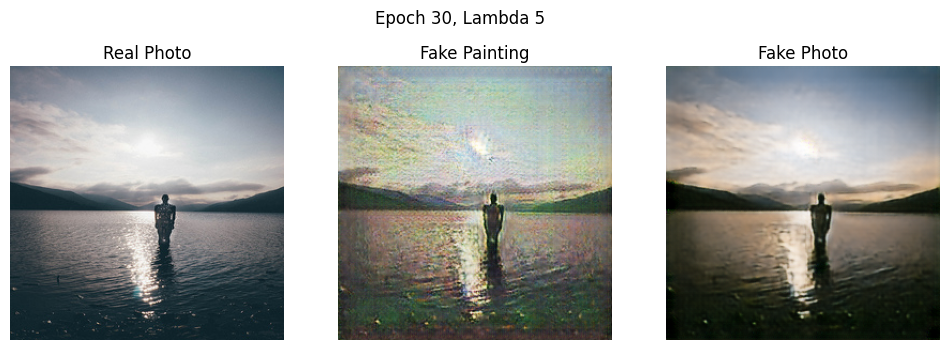

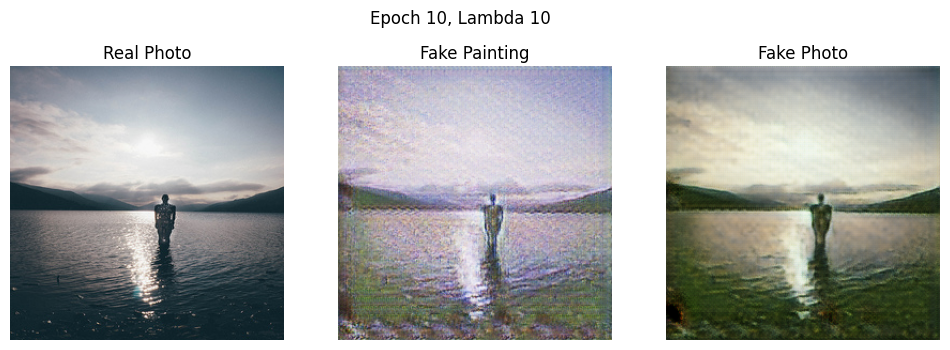

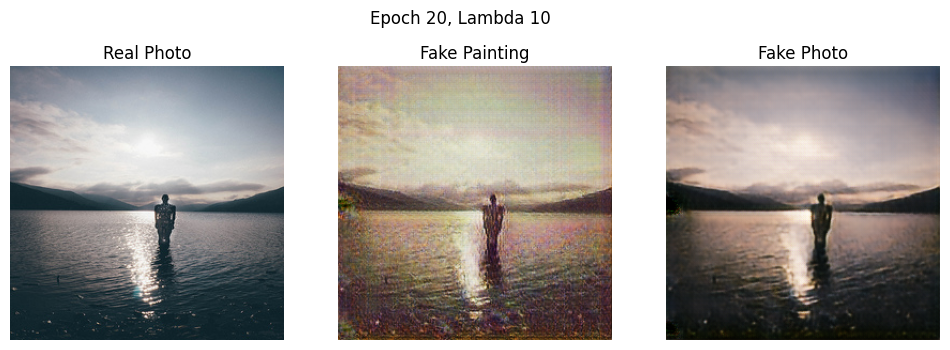

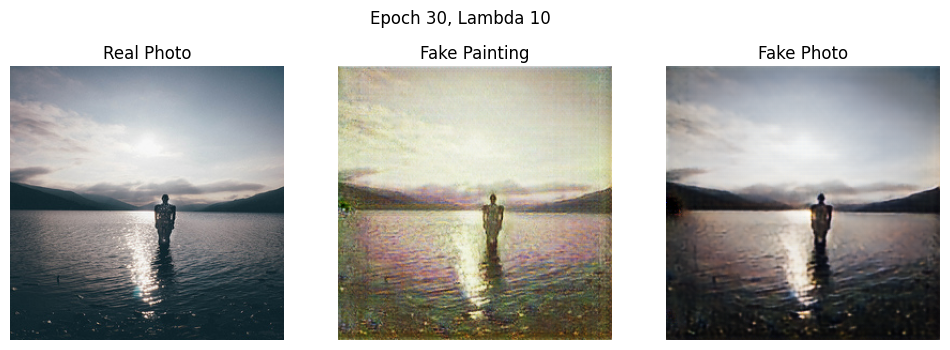

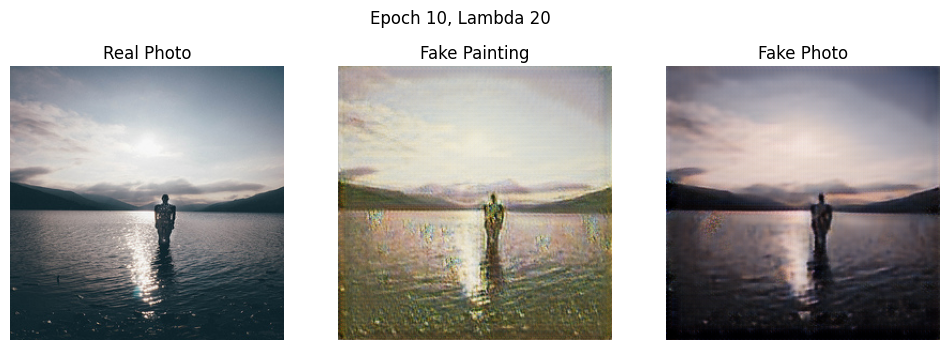

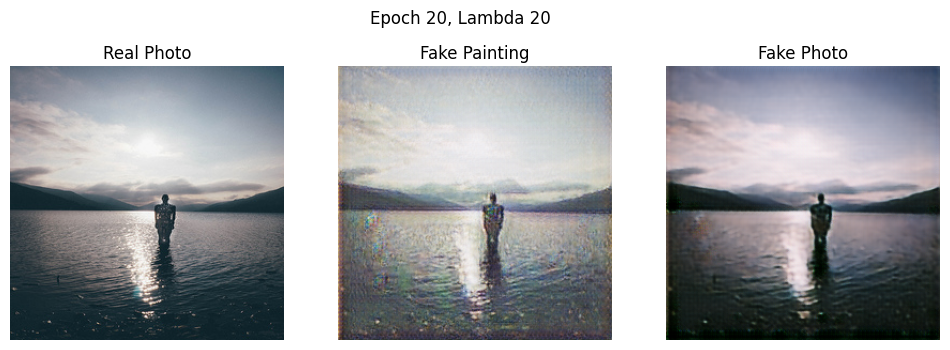

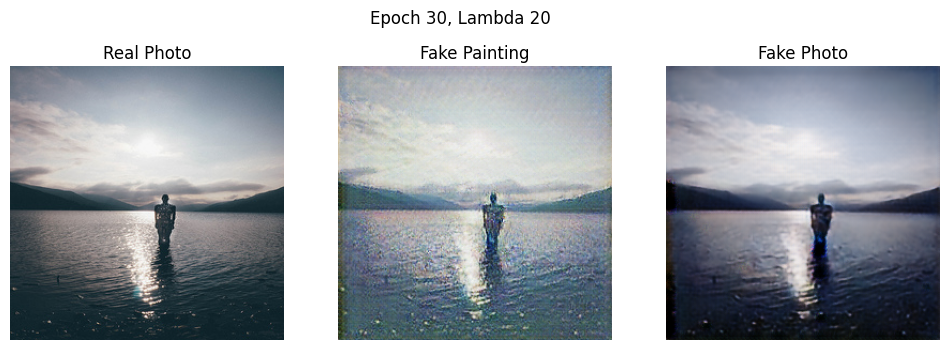

In [22]:
epochs = [10, 20, 30]
for l in lambdas:
    for e in epochs:
        load_weights_and_generate_images(real_photo, l, e)

- lower lambda values encourage more style transfer, but in the extreme case of lambda = 1, the content is not preserved at all
- higher lambda values encourage more content preservation, but in the extreme case of lambda = 20, the style is not transferred at all
- cycle